In [512]:
from scipy import stats
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

In [727]:
nuovo = pd.read_stata("../dati/td_ita.dta")
nuovo = nuovo[nuovo['first2w'].isin(['First two weeks'])]
nuovo = nuovo[['id', 'date_not','what', 'withw', 'where']]
nuovo.id = nuovo.id.astype(int)
nuovo = nuovo[(nuovo['what'] == 'Sport')  |  (nuovo['what'] == 'Walking')] 
sport_eve = nuovo
sport_eve['date_not'] = pd.to_datetime(sport_eve['date_not'])

In [728]:
# Building a way to check from code what weekday it was and storing weekends 
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0, 7):
    dictdays[i] = weekdays[i]

#list of weekend days in calendar time
weekend_clock_days = [14, 15, 21, 22, 28]

for day in weekend_clock_days:
    weekday = weekdays[sport_eve[sport_eve.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")

The date 14 was a Sat
The date 15 was a Sun
The date 21 was a Sat
The date 22 was a Sun
The date 28 was a Sat


In [733]:
sport_eve

,id,date_not,what,withw,where
69,0,2020-11-14 10:30:00,Walking,Partner,Countryside/mountain/hill/beach
72,0,2020-11-14 12:00:00,Walking,Partner,Countryside/mountain/hill/beach
73,0,2020-11-14 12:30:00,Walking,Partner,Countryside/mountain/hill/beach
75,0,2020-11-14 13:30:00,Walking,Partner,Countryside/mountain/hill/beach
76,0,2020-11-14 14:00:00,Walking,Partner,Countryside/mountain/hill/beach
...,...,...,...,...,...
266758,265,2020-11-23 16:00:00,Walking,Alone,In the street
266809,265,2020-11-24 17:30:00,Walking,Relative(s),In the street
266857,265,2020-11-25 17:30:00,Walking,Partner,In the street
267569,266,2020-11-17 08:30:00,Sport,Alone,Home apartment /room


# Filling in the missing, inactive status data

In [730]:
def today_or_yesterday(t): 
    if t.hour < 5:
        return days[t.day - 1]
    else:
        return days[t.day]

days = dict()
for i in range(sport_eve.date_not.dt.day.min(), sport_eve.date_not.dt.day.max() + 2 ):
    days[i-1] = i - sport_eve.date_not.dt.day.min()  

min_range = pd.date_range(start="2020-11-13 00:00:00", end="2020-11-30 23:59:59", freq='30T')
results = pd.DataFrame()
for user in sport_eve.id.unique():
    subset = sport_eve[sport_eve.id == user]
    complete_data = pd.DataFrame({'date_not': min_range})
    merged_df = pd.concat([complete_data, subset])
    merged_df['id'] = merged_df['id'].fillna(user)
    
    merged_df = merged_df.sort_values(by="what", na_position='first', ascending=False).drop_duplicates(keep='last', subset='date_not')
    
    merged_df['what'] = merged_df['what'].astype(str)
    merged_df['what'] = merged_df['what'].replace("nan", "Inactive")
    
    if merged_df.date_not.min() != complete_data.date_not.min() or merged_df.date_not.max() != complete_data.date_not.max():
        print()
        print(f"Some mistake occurred. \nThe amount of observation time is different than expected.\nUser: {user}, dates: {merged_df.date_not.min(), merged_df.date_not.max()}")
        print()
    if merged_df.shape[0] != complete_data.shape[0]: 
        print()
        print(f"Some mistake occurred. \nThe amount rows is different than expected.\nUser: {user}, length: {merged_df.shape[0]}, expected: {complete_data.shape[0]}")
        print()
    
    results = pd.concat([results, merged_df], ignore_index=True)
results['day'] = [today_or_yesterday(time) for time in results.date_not]

In [731]:
results.shape[0] #final result
complete_data.shape[0]*len(sport_eve.id.unique())   #total time any user has available during the experiment x n users
sport_eve.shape[0] #total each user had walked and did sports x n users
results.shape[0] - complete_data.shape[0]*len(sport_eve.id.unique())

# CHECK: EVERY HOUR (in a 24 day representing all the observation time) SHOULD HAVE THE SAME LENGTH.
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
experiment = results
experiment['hour'] = experiment['date_not'].dt.hour - 5
experiment['hour'] = [today_or_yesterday(hour) for hour in experiment['hour']]

total = []
for hour in experiment['hour'].unique():
    total.append(sum(experiment[experiment['hour']==hour][['what']].value_counts().sort_values()))
print(total)    

[7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092, 7092]


In [732]:
results

,date_not,id,what,withw,where,day,hour
0,2020-11-13 00:00:00,0.0,Inactive,NaN,NaN,0,19
1,2020-11-13 00:30:00,0.0,Inactive,NaN,NaN,0,19
2,2020-11-13 01:00:00,0.0,Inactive,NaN,NaN,0,20
3,2020-11-13 01:30:00,0.0,Inactive,NaN,NaN,0,20
4,2020-11-13 02:00:00,0.0,Inactive,NaN,NaN,0,21
...,...,...,...,...,...,...,...
170203,2020-11-30 22:30:00,266.0,Inactive,NaN,NaN,18,17
170204,2020-11-30 23:00:00,266.0,Inactive,NaN,NaN,18,18
170205,2020-11-30 23:30:00,266.0,Inactive,NaN,NaN,18,18
170206,2020-11-17 08:30:00,266.0,Sport,Alone,Home apartment /room,5,3


In [24]:
results[(results.id == 77) & (results.date_not >= "2020-11-25 22:00:00") &
          (results.date_not <= "2020-11-26 08:30:00")].sort_values(by='date_not').head(8)
#omg it worked

,date_not,id,what,withw,where,day,hour
55030,2020-11-25 22:00:00,77.0,Inactive,NaN,NaN,13,17
55031,2020-11-25 22:30:00,77.0,Inactive,NaN,NaN,13,17
55274,2020-11-25 23:00:00,77.0,Sport,Alone,Home apartment /room,13,18
55273,2020-11-25 23:30:00,77.0,Sport,Alone,Home apartment /room,13,18
55272,2020-11-26 00:00:00,77.0,Sport,Alone,Home apartment /room,13,19
55032,2020-11-26 00:30:00,77.0,Inactive,NaN,NaN,13,19
55033,2020-11-26 01:00:00,77.0,Inactive,NaN,NaN,13,20
55034,2020-11-26 01:30:00,77.0,Inactive,NaN,NaN,13,20


In [136]:
results.day.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

# By hour (all days in one), sport sessions. All 197 users.

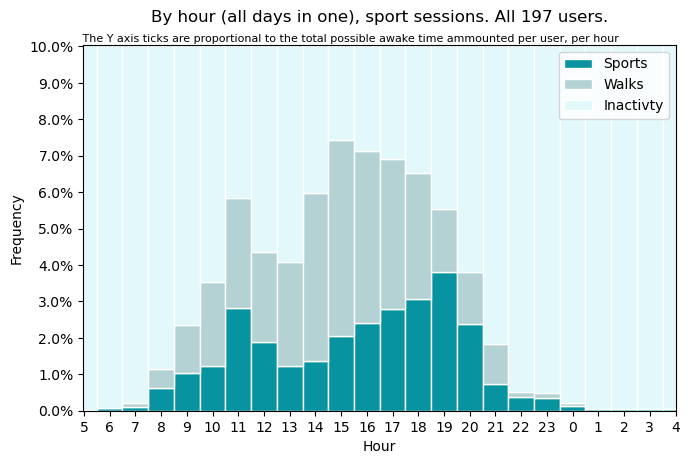

In [445]:
g = results
g['hour'] = g['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks', 'Inactivty'],
        color=("#0893a1", "#b4d1d4", "#e3f8fa")
       )

N = results[results['hour'] == 0].shape[0] - results[results['hour'] == 0].shape[0] * 7/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'By hour (all days in one), sport sessions. All 197 users.', y=1.04)
plt.suptitle("   The Y axis ticks are proportional to the total possible awake time ammounted per user, per hour", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byhour_everyday.png')

plt.show()

# By experiment day, all 197 users 

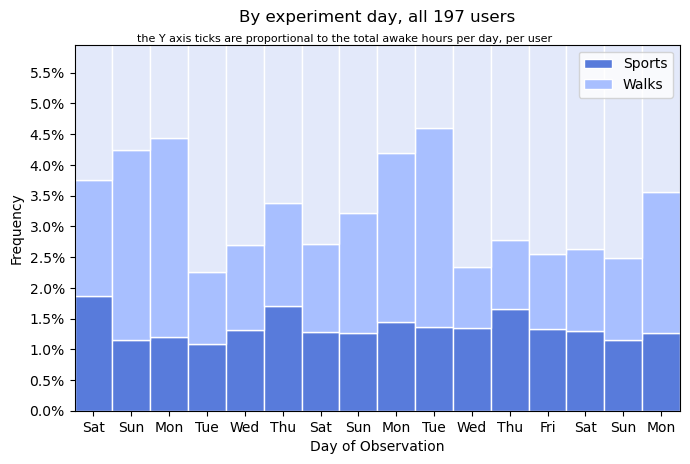

In [665]:
g = results[results.day != 0]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

ax.hist([g['day'][g['what'] == 'Sport'], g['day'][g['what'] == "Walking"], g['day'][g['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(g.day.unique()) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#587bdb", "#a8bfff", "#e3e9fa")
       )

N = results[results['hour'] == 0].shape[0] - results[results['day'] == 0].shape[0] * 7/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
list_of_days = ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu']*2
list_of_days.extend(['Fri', 'Sat', 'Sun', 'Mon', 'Tue'])
plt.xticks(np.arange(1, len(g.day.unique())), list_of_days)
plt.xlabel('Day of Observation')
plt.ylabel('Frequency')
plt.ylim(0, 0.06*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.xlim(0.5,16.5)
#plt.margins(x=-0.01)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'By experiment day, all 197 users', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total awake hours per day, per user", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byexperimentday_everyday.png')

plt.show()

# Lecture days (Monday to Friday) only, all 197 users

/tmp/ipykernel_799646/1123676736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['hour'] = g1['date_not'].dt.hour - 5
/tmp/ipykernel_799646/1123676736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1['hour'] = [today_or_yesterday(hour) for hour in g1['hour']]


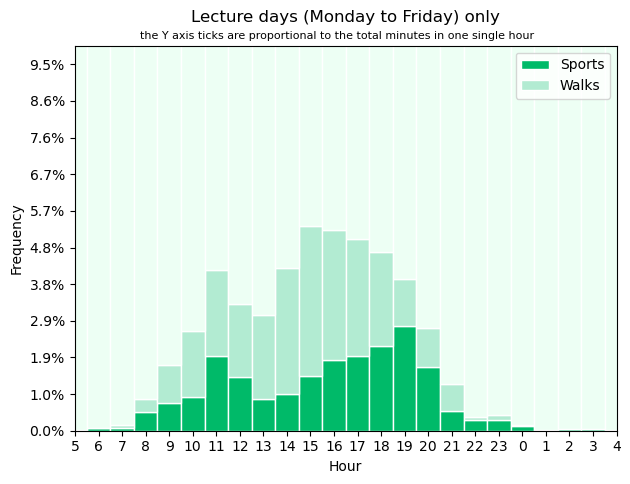

In [248]:
g1 = results[~results.day.isin(weekend_clock_days)]

g1['hour'] = g1['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g1['hour'] = [today_or_yesterday(hour) for hour in g1['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#00ba69", "#b2ebd2", "#edfff4")
       )
       
N = g1[g1.hour==0].shape[0]
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

plt.title(f'Lecture days (Monday to Friday) only', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('lecturedays.png')

plt.show()

# Weekends only, all 197 users

/tmp/ipykernel_799646/4025021726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['hour'] = g2['date_not'].dt.hour - 5
/tmp/ipykernel_799646/4025021726.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['hour'] = [today_or_yesterday(hour) for hour in g['hour']]


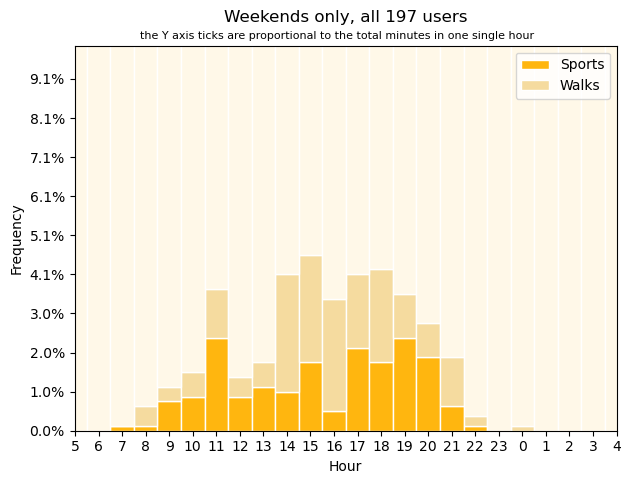

In [249]:
g2 = results[results.day.isin(weekend_clock_days)]

g2['hour'] = g2['date_not'].dt.hour - 5
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g2['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']],
        bins = np.arange(-0.5, len(custom_order) - 0.5, 1),
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#ffb60f", "#f5db9f", "#fff8e8")
       )
       
N = g2[g2.hour == 0].shape[0]
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=1))
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
plt.margins(x=-0.02)
ax.yaxis.set_major_locator(plt.MaxNLocator(12))

plt.title(f'Weekends only, all 197 users', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('weekends.png')

plt.show()

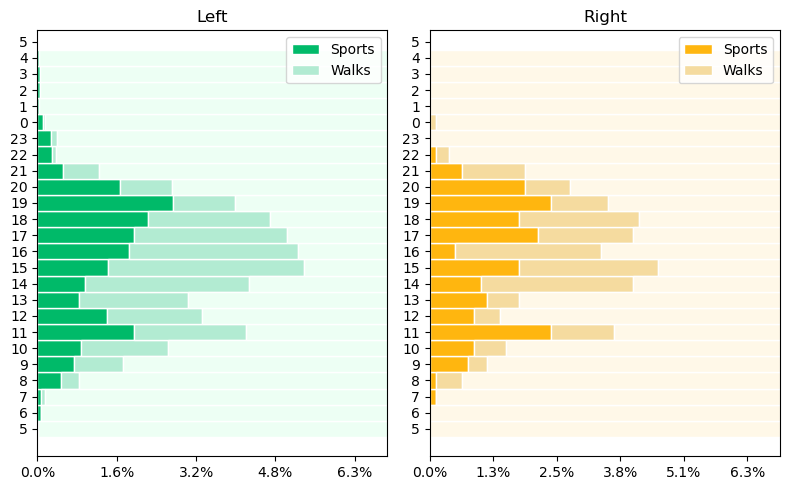

In [294]:
import matplotlib.pyplot as plt
import numpy as np

values1, values2 = [g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']], [g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']]

fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 2, 1)  # 2 rows, 1 column, first subplot
ax1.hist(values1,
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         stacked=True,
         edgecolor='white', label=['Sports', 'Walks'],
         color=("#00ba69", "#b2ebd2", "#edfff4"),
         orientation = "horizontal")
N1 = g1[g1['hour'] == 0].shape[0]
ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N1, decimals=1))
ax1.set_title('Left')
plt.yticks(np.arange(len(custom_order)), custom_order)
plt.xlim(0, 0.07*N1)
plt.legend()

# Second subplot
ax2 = fig.add_subplot(1, 2, 2)  # 2 rows, 1 column, second subplot
ax2.hist(values2,
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         stacked=True, edgecolor='white', label=['Sports', 'Walks'],
         color=("#ffb60f", "#f5db9f", "#fff8e8"),
         orientation = "horizontal")
N2 = g2[g2['hour'] == 0].shape[0]
ax2.xaxis.set_major_formatter(PercentFormatter(xmax=N2, decimals=1))
plt.yticks(np.arange(len(custom_order)), custom_order)
ax2.set_title('Right')
plt.xlim(0, 0.07*N2)
plt.legend()

plt.tight_layout()
plt

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  7.80it/s]


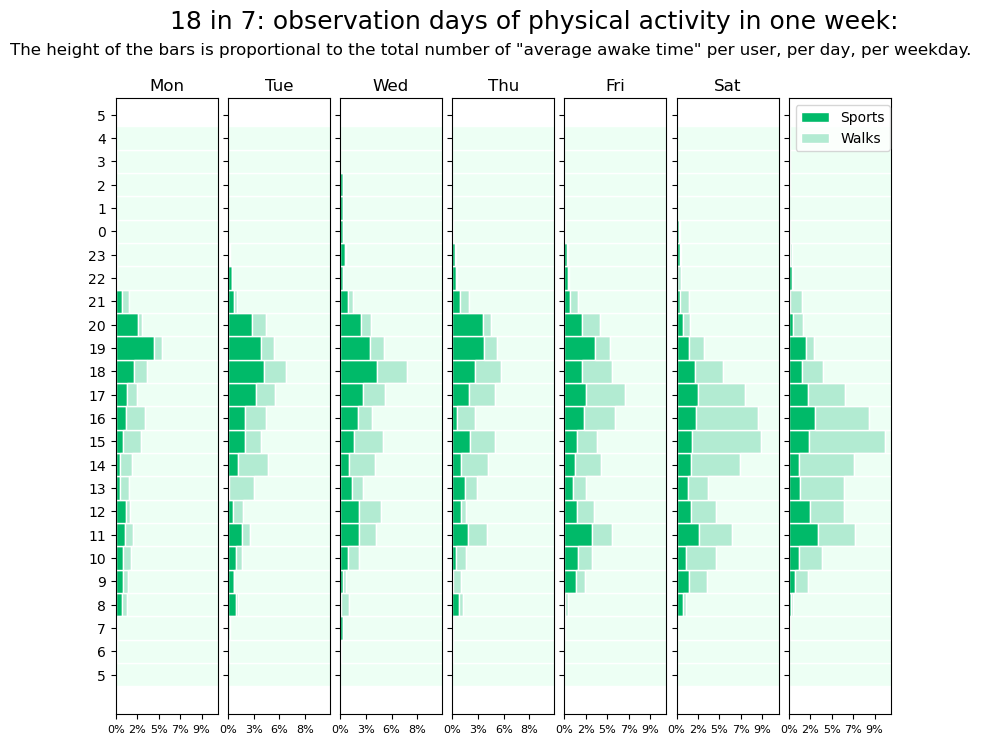

In [699]:
#For every day of the experiment, make one histogram. 
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']]
    ax1 = axs[current_day]
    ax1.hist(values,
             bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
             stacked=True,edgecolor='white', label=['Sports', 'Walks'],
             color=("#00ba69", "#b2ebd2", "#edfff4"),
             orientation = "horizontal")
    ax1.set_xticks([])
    N = g[g['hour'] == 0].shape[0]
    ax1.set_xlim([0, 0.11*N])
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))
    ax1.set_title(f'{weekdays[current_day]}')    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=8)
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    #.margins(y=-0.02)
    
    
fig.subplots_adjust(wspace=0.1)   
plt.suptitle('The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.', y=0.95)
plt.title("18 in 7: observation days of physical activity in one week:", fontsize=18, y=1.1 , x=-2.5)
plt.legend()
plt.savefig('a_typical_week.png')
plt.show()


19

# Breaking time down by sociodemographic factors.
From Maja's script, use sport.analysis.ipynb. Import Location, type of activity, company, start_time, end_time

In [700]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

In [701]:
td_dataset = pd.read_stata("data/td_ita.dta")  # time diaries dataset
demo_dataset = pd.read_stata("data/data4diarynew_ITA.dta") # demographics dataset
step_dataset = pd.read_csv("data/stepDetector_30min.csv") # step counter dataset

Cleaning procedure of the time diaries dataset.
We need to apply two steps:

   - consider only first two weeks of the survey
   - consider only the answers in which the users declared they are were doing any kind of sport activity

In [702]:
td_cleaned = td_dataset[td_dataset['first2w'] == 'First two weeks']
td_cleaned = td_cleaned[(td_cleaned["what"]=="Sport") | (td_cleaned["what"]=="I will participate in sports activities") |(td_cleaned["what"]=="Walking")]

Variable transformation

New variables we want to analyze are:
- the duration of the sport activity
- the location of the sport activity considering if the users is in 'private' space (indoor) or in public space (outdoor)
- with who the user is practicing sport: if alone or in company
- the type of sport activity the user is practicing


In [703]:
# duration of sport activity variable
new_td = td_cleaned
new_td['date_not'] = pd.to_datetime(new_td['date_not'])
new_td['date_dur'] = new_td['date_not'] - timedelta(hours = 5)

new_td = new_td .sort_values('date_dur') # sort the dataframe according to "date_dur"
new_td['time_diff'] = new_td['date_dur'].diff() # compute the time difference between adjacent rows

new_session = (new_td['time_diff'] > pd.Timedelta(minutes=30)) | new_td['time_diff'].isnull() # search for new start session
new_td['session'] = new_session.cumsum() # Creazione di un nuovo identificatore di sessione basato su new_session

collapsed_sessions = new_td.groupby(['id', 'session']).agg(
    start_time=('date_not', 'first'),
    end_time=('date_not', 'last'),
    duration=('date_dur', lambda x: ((x.max() - x.min()).total_seconds() / 60)+30)
).reset_index()

collapsed_sessions = collapsed_sessions.drop(columns='session')

# merge the two datasets
td_cleaned = td_cleaned.merge(collapsed_sessions, left_on=['id', 'date_not'], right_on=['id', 'start_time']) # inner join of the two datasets

# Data cleaning

After computing the duration of the sport session we need to apply two more data cleaning criteria:
1. we want to eliminate the sport session in which the type of sport is Walking and the duration is 30 minutes or less, because we cannot guarantee that the user is doing sport but likely they are just commuting to go somewhere.
2. we want also to eliminate the sport sessions in which the type of sport is Walking and the location is the university or grocery shops. In such cases the probability that the user is just walking is higher than the probability that the user is doing sport nearby these places.

In [704]:
# obtain the indexes of the rows satisfying condition 1
to_remove1 = list(td_cleaned[(td_cleaned['what']=='Walking') & (td_cleaned['duration']==30.0)].index)
print(td_cleaned.shape)
# remove these cases
td_cleaned = td_cleaned.drop(index=to_remove1)
print(td_cleaned.shape)
# obtain the indexes of the rows satisfying condition 2
places = [ 'Supermarket …', 'Street markets', 'Grocery Shop', 'University Library', 'Other university place']
to_remove2 = list(td_cleaned[(td_cleaned['what']=='Walking') & (td_cleaned['where'].isin(places))].index)

# remove these cases
td_cleaned = td_cleaned.drop(index=to_remove2)
print(td_cleaned.shape)

(1325, 105)
(1044, 105)
(1033, 105)

# location of sport activity variable
td_cleaned['where recoded'] = td_cleaned['where'].replace(['Home apartment /room', 'Weekend home or holiday apartment', 'House (friends others)', 'Relatives Home', 'Home garden/patio/courtyard',
                                                           'Another indoor place', 'Gym, swimming pool, Sports centre …', 'Other university place', 'Countryside/mountain/hill/beach', 'In the street', 'Another outdoor place', 'Café, pub, bar', 'Shops, shopping centres', 'Not answer'],
                                                          ['indoor', 'indoor', 'indoor', 'indoor', 'indoor',
                                                           'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'not specified'])
td_cleaned['where recoded'] = td_cleaned['where recoded'].cat.remove_unused_categories()

# company during sport activity variable
td_cleaned['withw recoded'] = td_cleaned['withw'].replace(['Partner', 'Friend(s)', 'Relative(s)', 'Roommate(s)', 'Other', 'Colleague(s)',
                                                           'Classmate(s)',
                                                           'Alone',
                                                           'Not answer'],
                                                          ['company', 'company', 'company', 'company', 'company', 'company', 'company',
                                                           'alone',
                                                           'not specified'])

td_cleaned['withw recoded'] = td_cleaned['withw recoded'].cat.remove_unused_categories()

# type of sport activity variable
td_cleaned['sport recoded'] = td_cleaned['sport'].replace(['Walking, Trekking, and hiking',
                                                           'Jogging and running',
                                                           'Cycling, skiing, and skating', 'Ball games', 'Other outdoor activities',
                                                           'Gymnastics and fitness',
                                                           'Water sports', 'Other indoor activities'
                                                           ],
                                                          ['Walking, Trekking, and hiking',
                                                           'Jogging and running',
                                                           'Outdoor activities', 'Outdoor activities', 'Outdoor activities',
                                                           'Gymnastics and fitness',
                                                           'Other indoor activities', 'Other indoor activities'
                                                           ])

# adding the category Walking to the sport activity
td_cleaned['sport recoded'] = td_cleaned['sport recoded'].cat.add_categories('Walking')
td_cleaned.loc[td_cleaned['what'] == 'Walking', 'sport recoded'] = 'Walking'

td_cleaned['sport recoded'] = td_cleaned['sport recoded'].cat.remove_unused_categories()

# useful conversions
td_cleaned['id'] = td_cleaned['id'].astype(int)
demo_dataset['userid'] = demo_dataset['userid'].astype(int)
td_cleaned['hours'] = td_cleaned['date_not'].dt.hour

new_dataset = td_cleaned.copy()
new_dataset = new_dataset[['id', 'start_time', 'week', 'DD_not', 'hh_not', 'sport recoded', 'duration', 'where recoded', 'withw recoded', 'date_not']]
cat_dataset = new_dataset.merge(demo_dataset, left_on='id', right_on='userid', how='left')

cat_dataset = cat_dataset[[ 'id', 'duration','sport recoded', 'where recoded', 'withw recoded','degree', 'department', 'w1_A01', 'date_not']]
cat_dataset.columns = ['id', 'duration', 'type of activity', 'location', 'company', 'degree', 'department',  'sex', 'timestamp']

(1325, 105)
(1044, 105)
(1033, 105)


# END OF MAJA's CONTRIBUTION
Back to time visualization, this very useful section serves the purpose to distinguish specific sessions that are legitimately over-the-median physical activity from any kind of bodily movement. In the following sections, I will keep in my time diary only the events that belong to active sport sessions and forget the ones who just represent "short commuting" or "too short sessions" to be considered relevant anyway. 


In [705]:
#First thing: remove the users that have no qualified sport sessions 
print(f"Difference in id number from clean to cleaner: {len(sport_eve.id.unique())} - {len(cat_dataset.id.unique())} = {len(sport_eve.id.unique()) - len(cat_dataset.id.unique())}")
to_remove = list(sport_eve[~(sport_eve['id'].isin(cat_dataset.id.unique()))].index)
print(f"Rows:{sport_eve.shape[0]}")
print('removing...')
cl_sport_eve = sport_eve.drop(index=to_remove)
print(f"Rows:{cl_sport_eve.shape[0]}")
print(len(cl_sport_eve.id.unique()))

Difference in id number from clean to cleaner: 197 - 180 = 17
Rows:3409
removing...
Rows:3379
180


In [725]:
# reminder: sport_eve is the dataset from the raw data that has 
# all the events in which users indicated they were walking or doing sports. 
# it does not have the inactive events (that were artificially added as you see in previous sections. 

        #Baby example of what's going on: 

    # for every user, for every observation in the cleaner dataset:
    
user = 9
first = cat_dataset[cat_dataset.id == 9].sort_values(by='timestamp').timestamp.tolist()[0]  #[0] means I only get the first as an example
print(first)
#the end is just the start + duration time so:
duration_in_hours = cat_dataset[cat_dataset.id ==9].sort_values(by='timestamp').duration.tolist()[0] // 60
second = first + timedelta(hours=duration_in_hours, seconds=1)

#window of time for acceptable observations:
range_to_check = pd.date_range(start=first, end=second, freq='30T')

    #for every user, for every observation:
user_data = cl_sport_eve[cl_sport_eve.id == 9].sort_values(by='date_not')
print(user_data)
to_keep = user_data.date_not.isin(range_to_check)
print(to_keep)
#user_data[to_keep]  #now only outputting the events during a sport session.

# Ta daa! Now I will automate this process.

2020-11-15 10:30:00
       id            date_not     what        withw  \
10059   9 2020-11-13 16:30:00  Walking  Relative(s)   
10143   9 2020-11-15 10:30:00  Walking  Relative(s)   
10144   9 2020-11-15 11:00:00  Walking  Relative(s)   
10145   9 2020-11-15 11:30:00  Walking  Relative(s)   
10146   9 2020-11-15 12:00:00  Walking  Relative(s)   
10151   9 2020-11-15 14:30:00  Walking    Friend(s)   
10152   9 2020-11-15 15:00:00  Walking    Friend(s)   
10153   9 2020-11-15 15:30:00  Walking    Friend(s)   
10211   9 2020-11-16 20:30:00    Sport        Alone   
10443   9 2020-11-21 16:30:00  Walking    Friend(s)   
10444   9 2020-11-21 17:00:00  Walking    Friend(s)   
10445   9 2020-11-21 17:30:00  Walking    Friend(s)   
10447   9 2020-11-21 18:30:00  Walking    Friend(s)   
10448   9 2020-11-21 19:00:00  Walking    Friend(s)   
10545   9 2020-11-23 19:30:00    Sport  Relative(s)   
10546   9 2020-11-23 20:00:00    Sport  Relative(s)   
10547   9 2020-11-23 20:30:00    Sport  Relat

In [726]:
cat_dataset[cat_dataset.id == 9].sort_values(by='timestamp').timestamp

43   2020-11-15 10:30:00
44   2020-11-16 19:30:00
45   2020-11-21 16:30:00
46   2020-11-23 19:30:00
47   2020-11-24 19:30:00
48   2020-11-25 17:00:00
49   2020-11-26 20:00:00
50   2020-11-28 16:30:00
51   2020-11-30 20:00:00
Name: timestamp, dtype: datetime64[ns]

In [734]:
clean_events = pd.DataFrame()
for user in tqdm(cl_sport_eve.id.unique()):
    first = cat_dataset[cat_dataset.id == user].sort_values(by='timestamp').reset_index().timestamp.tolist()
    duration_in_hours = (cat_dataset[cat_dataset.id == user].sort_values(by='timestamp').duration / 60).tolist()
    second = [first[i] + timedelta(hours=duration_in_hours[i], seconds=1) for i in range(len(duration_in_hours))]
    #first and second are now ready. 
    for i in range(len(first)):
        range_to_check = pd.date_range(start=first[i], end=second[i], freq='30T')
        
        #masking the other, less clean but eventful dataset 
        user_data = cl_sport_eve[cl_sport_eve.id == user].sort_values(by='date_not')
        to_keep = user_data.date_not.isin(range_to_check)
        user_data[to_keep]  
    clean_events = pd.concat([clean_events, user_data], ignore_index=True)    
    

100%|█████████████████████████████████████████| 180/180 [00:03<00:00, 51.78it/s]


In [735]:
clean_events

,id,date_not,what,withw,where
0,0,2020-11-14 10:30:00,Walking,Partner,Countryside/mountain/hill/beach
1,0,2020-11-14 12:00:00,Walking,Partner,Countryside/mountain/hill/beach
2,0,2020-11-14 12:30:00,Walking,Partner,Countryside/mountain/hill/beach
3,0,2020-11-14 13:30:00,Walking,Partner,Countryside/mountain/hill/beach
4,0,2020-11-14 14:00:00,Walking,Partner,Countryside/mountain/hill/beach
...,...,...,...,...,...
3374,265,2020-11-23 16:00:00,Walking,Alone,In the street
3375,265,2020-11-24 17:30:00,Walking,Relative(s),In the street
3376,265,2020-11-25 17:30:00,Walking,Partner,In the street
3377,266,2020-11-17 08:30:00,Sport,Alone,Home apartment /room


In [710]:
clean_events
#everything you see below was done at the start of this notebook, it's for making
# data more machine - readable
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(0, 7):
    dictdays[i] = weekdays[i]
weekend_clock_days = [14, 15, 21, 22, 28]
print("The weekends:")
for day in weekend_clock_days:
    weekday = weekdays[clean_events[clean_events.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")
def today_or_yesterday(t): 
    if t.hour < 5:
        return days[t.day - 1]
    else:
        return days[t.day]

days = dict()
for i in range(sport_eve.date_not.dt.day.min(), sport_eve.date_not.dt.day.max() + 2 ):
    days[i-1] = i - sport_eve.date_not.dt.day.min()  

min_range = pd.date_range(start="2020-11-13 00:00:00", end="2020-11-30 23:59:59", freq='30T')
results = pd.DataFrame()

for user in clean_events.id.unique():
    subset = clean_events[clean_events.id == user]
    complete_data = pd.DataFrame({'date_not': min_range})
    merged_df = pd.concat([complete_data, subset])
    merged_df['id'] = merged_df['id'].fillna(user)
    
    merged_df = merged_df.sort_values(by="what", na_position='first', ascending=False).drop_duplicates(keep='last', subset='date_not')
    
    merged_df['what'] = merged_df['what'].astype(str)
    merged_df['what'] = merged_df['what'].replace("nan", "Inactive")
    
    if merged_df.date_not.min() != complete_data.date_not.min() or merged_df.date_not.max() != complete_data.date_not.max():
        print()
        print(f"Some mistake occurred. \nThe amount of observation time is different than expected.\nUser: {user}, dates: {merged_df.date_not.min(), merged_df.date_not.max()}")
        print()
    if merged_df.shape[0] != complete_data.shape[0]: 
        print()
        print(f"Some mistake occurred. \nThe amount rows is different than expected.\nUser: {user}, length: {merged_df.shape[0]}, expected: {complete_data.shape[0]}")
        print()
    
    results = pd.concat([results, merged_df], ignore_index=True)
results['day'] = [today_or_yesterday(time) for time in results.date_not]

results.shape[0] #final result
complete_data.shape[0]*len(sport_eve.id.unique())   #total time any user has available during the experiment x n users
sport_eve.shape[0] #total each user had walked and did sports x n users
results.shape[0] - complete_data.shape[0]*len(sport_eve.id.unique())

# CHECK: EVERY HOUR (in a 24 day representing all the observation time) SHOULD HAVE THE SAME LENGTH.
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
experiment = results
experiment['hour'] = experiment['date_not'].dt.hour - 5
experiment['hour'] = [today_or_yesterday(hour) for hour in experiment['hour']]

total = []
for hour in experiment['hour'].unique():
    total.append(sum(experiment[experiment['hour']==hour][['what']].value_counts().sort_values()))
print(total)    

The weekends:
The date 14 was a Sat
The date 15 was a Sun
The date 21 was a Sat
The date 22 was a Sun
The date 28 was a Sat
[6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480, 6480]


# Changes after cleaning
If you go back to the start of this notebook you will notice that:
- simply just selecting any walk and any sport session produces a dataset that has 3409 events.
- selecting walks and sport sessions longer than 30 minutes produces a dataset with 3379 events.

This means that there are only **30 events that do not belong to any 30+ longer activity session**, and they're about 0.88% of the raw physical activity data. 

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.49it/s]


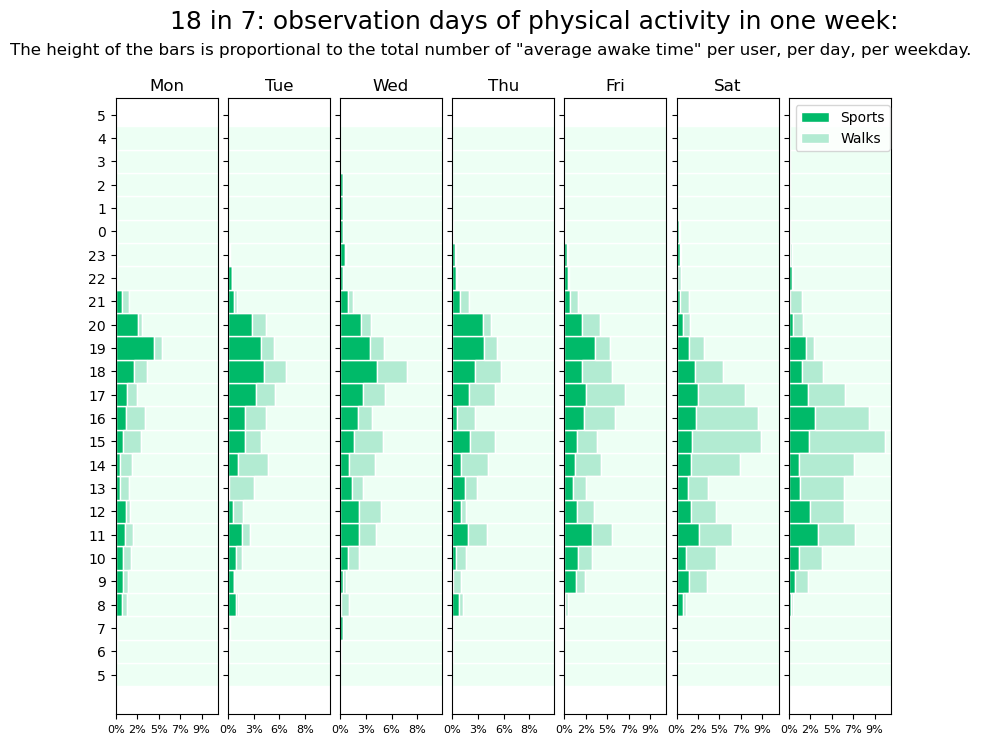

In [712]:
#For every day of the experiment, make one histogram. 
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"], g['hour'][g['what'] == 'Inactive']]
    ax1 = axs[current_day]
    ax1.hist(values,
             bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
             stacked=True,edgecolor='white', label=['Sports', 'Walks'],
             color=("#00ba69", "#b2ebd2", "#edfff4"),
             orientation = "horizontal")
    ax1.set_xticks([])
    N = g[g['hour'] == 0].shape[0]
    ax1.set_xlim([0, 0.11*N])
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))
    ax1.set_title(f'{weekdays[current_day]}')    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=8)
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    #.margins(y=-0.02)
    
    
fig.subplots_adjust(wspace=0.1)   
plt.suptitle('The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.', y=0.95)
plt.title("18 in 7: observation days of physical activity in one week:", fontsize=18, y=1.1 , x=-2.5)
plt.legend()
plt.savefig('a_typical_week.png')
plt.show()
